<center><h1>  OpenStreetMap Data Wrangling </h1> </center>
<center><h3> Udacity Data Analyst Nanodegree Project 3 </h3></center>


### Introduction

OpenStreetMap (OSM) is an open-source project attempting to created a [free map of the entire world](https://www.openstreetmap.org/#map=2/54.3/7.6) from volunteer-entered data. It is maintained by the [OpenStreetMap foundation](https://wiki.osmfoundation.org/wiki/Main_Page) and is a colloborative effort with over 2 million contributors. OpenStreetMap data is freely available to download in many formats and presents an ideal opportunity to practice the art of data wrangling for several reasons:

* The entire dataset is user-generated meaning there will be a significant quantity of "dirty" data
* The dataset is for any area is free to download in many formats including XML
* The data are relatable and human-understandable because they represent real places and features

I decided to work with the metro area of Cleveland because it is where I currently attend university, and I thought it would be intriguing to explore the city through the dataset after many hours spent experiencing the city on the ground. The data extract of Cleveland used for this project was downloaded from [Mapzen Metro Extracts](https://mapzen.com/data/metro-extracts/metro/cleveland_ohio/).

### Retrieval/Preliminary Exploration

The first step was to download the map as an XML file. The original file clocked in at nearly 5.5 million lines, which was somewhat unwieldy for testing the first versions of auditing and cleaning scripts. Consequently, I decided to create smaller sample XML files for the first runs of the auditing scripts and for identifying the most common problems that would need to be cleaned. Using a provisional sampling script, I created a small file that contained one out of every 100 top-level element, and an intermediate size script that kept one out of 10 top-level elements. There are three core, top-level elements in OSM:
1. [Nodes](http://wiki.openstreetmap.org/wiki/Node) represent a single point and have an id, latitude, and longitude. They may also contain descriptive tags that elaborate on the node if it is on an item of interest
2. [Ways](http://wiki.openstreetmap.org/wiki/Way) are made up of ordered lists of nodes that describe a linear feature such as a trail, or an area such as a park. They contain a list of the nodes that comprise the way as well as tags for detailed information.
3. [Relations](http://wiki.openstreetmap.org/wiki/Relation) are comprised of an ordered list of members that can be either nodes or ways. They are used to represent logically or geographic relationships between features and contain a list of members as well as tags describing the element.

The breakdown of top-level elements for the three file sizes is summarized in the following table:

|                     	    | 'node'  	| 'way'  	| 'relation' 	| File Size (MB) 	|
|-----------------------	|---------	|--------	|------------	|----------------	|
| __Full file__          	| 1795742 	| 189248 	| 3732       	|      392.6     	|
| __Intermediate sample__ 	| 179575  	| 18924  	| 374        	|      39.9      	|
| __Small sample__        	| 17958   	| 1892   	| 38         	|       3.9      	|

### Data Auditing and Cleaning Approach

Being in control of a large dataset can be both exciting and intimidating! There are numerous possiblities for exploration, but the sheer amount of information can be overwhelming. Before I officially began any data wrangling, I wanted to have a step-by-step plan in order to efficiently go through the process of auditing and cleaning the data. I decided on the following approach, adapted from the Udacity course on Data Wrangling:

1. Audit the data: identify errors/missing or generally "dirty" data in the original XML file
2. Create a data cleaning plan based on the audit
    * Identify the causes of any inconsistent/incorrect data 
    * Develop a set of corrective cleaning actions and test on a small sample of the XML data
3. Implement the data cleaning plan: run cleaning scripts and transfer the cleaned data to .csv files
4. Manually correct as necessary: import the data from .csv files to a SQL database and perform SQL queries on the data to identify any further inconsistencies that would necessitate returning to step 1. 

Data wrangling is an iterative procedure, and as such, I expected that I might need to work through these steps several times. Moreover, I knew that having a clear outline of the procedure to follow would save me untold hours of work and confusion.


#### Data Quality

There are five main aspects of data quality to consider when auditing a dataset:

* __Validity__: Does the data conform to a standard format?
* __Accuracy__: Does the data agree with reality or with a trusted external source?
* __Completeness__: Are all records present?
* __Consistency__: Is data in a field or across a row in logical agreement?
* __Uniformity__: Are the same units used for a given field?

### Auditing and Cleaning

#### Elevation

Looking at the official documentation for [elevation data in OpenStreetMap](http://wiki.openstreetmap.org/wiki/Altitude), elevation in tags should be recorded in meters. Furthermore, from the [United States Geological Survey list of elevation of major cities](https://egsc.usgs.gov/isb//pubs/booklets/elvadist/elvadist.html), I can see that the elevation of Cleveland ranges from 571' at the lowest point to 1050' at the highest point. Therefore, after converting to meters, all elevation data encoded in node tags should be between 174 m and 320 m. This would be a test for both uniformity, because all elevation data should use the same units, and accuracy as I was checking the elevations against a trusted source. The following code was used to find elevation points outside of the acceptable range and invalid elevations:

```python 

def audit():
	suspect_elevations = []
	invalid_elevations = []

	for _, elem in ET.iterparse(map_file):
		if elem.tag == 'tag':
			if elem.attrib['k'] == 'ele':
				try: # Try to convert the elevation to an integer
					elevation = int(elem.attrib['v'])
					if elevation > 320 or elevation < 124: # Elevation limits in meters identified from the USGS
						suspect_elevations.append(elevation)
				except: #
					invalid_elevations.append(elem.attrib['v'])
```

The audit identified any elevations above or below those measures, as well as any elevations that could not be cast to an integer. I could have used regular expressions to identify problematic characters, but since I expected all the elevations to be integers, the simpler approach was to attempt to cast all the elevation data to integers. This initial effort yielded 2516 suspect elevations and 5 problem elevations in the entire dataset. I decided that assuming all the elevations above or below the accepted limits were false was a mistake. The USGS data was for the city of Cleveland itself, and my map included surrounding areas. Therefore, I took a closer look at the suspect elevations. The four highest values were [1188, 423, 419, 414] and the four lowest were [3, 3, 42, 321]. I decided that 423 m was a reasonable elevation for the surrounding area of Cleveland. However, clearly the 1188 was meant to be in feet, and the three lowest points were not realistic. I made the choice to eliminate the three lowest elevation tags and convert the largest value to meters. The elevations with bad characters were ['318;313', '304.5', '298.4', '679"', '348;352;358']. I decided to take the first elevation listed if there were multiple entries and convert the entry in feet to meters. Total, this meant I only had to correct 9 problem elevations out of 6500. That makes me confident that the accuracy and uniformity of the dataset was initially very high. 

The actual cleaning of the elevation data would take place when I converted the XML into CSV files. I created a mapping for correcting the elevations and implemented it in the following code:

```python

# The main data cleaning script will drop the tag if it encounters an empty string
elevation_mapping = {'3': '',
					 '42': '',
					 '1188' : '362',
					 '318;313' : '318',
					 '304.5' : '305',
					 '298.4' : '298',
					 '679"': '207',
					 '348;352;358' : '348'}

def clean(elevation):
	if elevation in elevation_mapping:
		elevation = elevation_mapping[elevation]
    return elevation
```

The result of running the code on the problem elevations is:
```
3 --> 
3 --> 
42 --> 
1188 --> 362
318;313 --> 318
304.5 --> 305
298.4 --> 298
679" --> 207
348;352;358 --> 348
```

#### Amenities

The amenity tags associated with way elements was one facet of the data I could audit for validity, or conformation to a schema. The OpenStreetMap wiki has a [page on the amenity key](http://wiki.openstreetmap.org/wiki/Key:amenity). This webpage shows all of the accepted amenities in OpenStreetMap and gives the purpose of the amenity tag: "To cover an assortment of community facilities including toilets, telephones, banks, pharmacies and schools." I wanted to check if all the amenities tags in the Cleveland dataset were among the officially validated tags from OpenStreetMap. To do so, I downloaded the source of the webpage as XML and extracted all of the amentities from the table using the python XML module. I then compared the amentities in the Cleveland OpenStreetMap XML file to this set using the following code:



```python
def audit():
	# Iterate through the osm file
	for _ , elem in ET.iterparse(map_file):
		# Iterate through all the tags named tag
		for entry in elem.iter('tag'):
			# Find the amenity attributes
			if entry.attrib['k'] == 'amenity':
				amenity = entry.attrib['v']
				# Count the number of times each amenity appears in the data
				# If amenity is not in dictionary, start counting at one
				# If the amenity is in the dictionary, increment the count
				count_amenities[amenity] = count_amenities.get(amenity, 0) + 1

	# Create a tree for parsing the XML from the webpage
	source_tree = ET.parse(source_file)
	source_root = source_tree.getroot()

	# The list of verified amenities will be a set of unique names
	amenities_from_source = set()

	# Table class has been identified from inspection of the HTML
	for table in source_root.iter('table'):
		if table.attrib['class'] == 'wikitable':
			for row in table:
				#Iterate through the data in each row of the table
				for data in row:
					for element in data:
						if element.tag == 'a': # The entries in the table are under 'a' tags
							if element.text:
								amenities_from_source.add(element.text.strip())

	# Identify the amenities in the map not verified on the openstreetmap website
	non_verified_amenities = dict()

	for key in count_amenities:
		if key not in amenities_from_source:
			# If key is not in dictionary, start counting at one
			# If the key is in the dictionary, increment the count
			non_verified_amenities[key] = non_verified_amenities.get(key, 0) + 1
            
```
I did not necessarily want to delete the amentities that could not be validated, but rather, I would reclassify them into the amenity categories already part of OpenStreetMap. The non-verified amentities and the number of times they occured in the dataset are presented below:
```python
{'childcare': 1, 'public_building': 1, 'Court House': 1, 'Government': 1, 'funeral_home': 1, 'gym': 1, 'swimming_pool': 1, 'music_venue': 1, 'bail_bonds': 1, 'social_club': 1, 'bell': 1, 'compressed_air': 1, 'hackerspace': 1, 'raspberries': 1, 'picnic_table': 1, 'child_care': 1, 'boat_rental': 1, 'library;theatre': 1, 'trade_school': 1, 'grill': 1, 'slipway': 1, 'winery': 1, 'boat_storage': 1, 'dog_park': 1, 'park': 1, 'nursery': 1, 'retirement_home': 1, 'printer': 1, 'hospice': 1}
```

As can be seen, none of the non-verified amenities occured more than once. Furthermore, several of the amenities were not in agreement with the purpose of the tag from the documentation and would be better placed under tags such as "leisure." Therefore, I concluded that it would be best to reclassify the amenities that could not be verified according to the official dichotomy rather than modify the official list. I created a mapping based on the official description of the amenities and my judgement and applied it when converting the XML data to CSV files. 

```python
def clean(amenity):
	if amenity in amenities_mapping:
		amenity = amenities_mapping[amenity]
	return amenity
```


####  Street Types

Another audit I could perform for validity as well as consistency, concerned the street names associated with the node and way tag. From my initial exploratory examination of the data, I had noticed a wide variety in street name endings and abbreviations. Using a provisional street name auditing script, I compared the street endings to a standardized list and counted the number of times each non-standard type appeared using the following function:

```python

# Search street name for problematic characters
street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)

# Standard street names
expected = ["Street", "Avenue", "Boulevard", "Drive", "Court", "Place", "Square", "Lane", "Road", 
            "Trail", "Parkway", "Commons"]

def audit_street_type(street_types, street_name):
    # Check to make sure there are no unexpected characters in the street name
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        if street_type not in expected: 
            # Add the non-standard street names to a set within a dictionary
            street_types[street_type].add(street_name)

# Check if the tag refers to a street name
def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")


def audit(osmfile):
    osm_file = open(osmfile, "rb")
    street_types = defaultdict(set)
    for event, elem in ET.iterparse(osm_file):
        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_street_name(tag): #Check to see if the tag contains a street name
                    audit_street_type(street_types, tag.attrib['v']) # Find the problematic street names
    osm_file.close()
    return street_types
    
if __name__ == '__main__':
    street_types = audit(osmfile)
    for street in street_types:
        count_dict[street] = len(street_types[street])
```

That produced the following dictionary listing the non-standard street names and the number of occurences:

```python
{'ave': 1, 'Rd': 29, 'NW': 6, 'St.': 5, 'Ave.': 9, 'NE': 2, 'Northeast': 15, 'Circle': 9, 'Rauscher': 1, 'Blvd': 10, 'St': 10, 'Blvd.': 2, 'Cedar': 1, 'Arlington': 1, 'Engel': 1, 'Fleet': 1, 'Ave': 9, 'Center': 1, 'Rd.': 3, 'Ln': 1, 'Mayfield': 1, 'East': 7, 'Clair': 1, 'North': 1, 'Southeast': 8, 'Lee': 1, 'Northwest': 16, 'West': 4, 'Path': 3, 'Smith': 1, '106': 1, 'Pkwy': 2, 'South': 2, 'Extension': 1, 'Shoreway': 1, 'Fairgrounds': 1, 'Ravenna': 1, 'Dr': 6, 'SE': 3, '303': 1, 'Southwest': 4, 'W': 2, 'Pike': 1, 'OH-14': 1, 'Parschen': 1, '534': 1, '3': 1, 'OH-18': 1, '6': 1, 'B': 2, '6A': 1, '100': 1, 'A': 2, '10': 1, 'Way': 6, 'st': 2, '250N': 1, 'SW': 1, 'Middleton': 1, '150th': 1, 'Lorain': 1, 'Esplanade': 2, '14': 2, 'Ridge': 1, '43': 1, 'Dr.': 1, '20': 1, 'Cut': 1, 'Plaza': 1, 'Soutwest': 1, '1175': 1, 'Terrace': 1, 'Hill': 1, '88': 1, '336': 1, '1102': 1, 'rd': 1, 'N.E.': 1, 'Downs': 1, 'Street.': 1, 'Paula': 1}
```

In order to standardize the street names, I created a mapping and applied it to the data during the conversion from XML to CSV files: 

```python
def clean(name):
    name = name.split(" ")
    if name[-1] in street_mapping:
        name[-1] = street_mapping[name[-1]]
    name = ' '.join(name)
    return name
```

The street mapping produces the following output:
```python
St --> Street
St. --> Street
st --> Street
Ave --> Avenue
Ave. --> Avenue
Rd --> Road
Rd. --> Road
ave --> Avenue
Blvd --> Boulevard
Blvd. --> Boulevard
Ln --> Lane
North --> N
South --> S
East --> E
West --> W
Northeast --> NE
Northwest --> NW
Southeast --> SE
Southwest --> SW
Dr. --> Drive
Pkwy --> Parkway
```


#### Postcodes

An additional audit I could perform for accuracy was on the postal codes (also known as ZIP codes in the United States for Zone Improvement Plan). My approach with the postal codes was to find a complete and trusted list of all the postal codes in the area I had downloaded, and then compare those to the postal codes in the OpenStreetMap file. The first step was to find all the postal codes. I initially searched for Cleveland zip codes and found the United States Postal Service data for postal codes in Cleveland. However, after finding that an alarmingly large percentage of the post codes in the XML file were not in this list,  I realized that the area I had downloaded was a square and did not conform to the administrative boundaries of the city of Cleveland. My next approach was to examine the XML I had downloaded and find the latitude and longitude boudaries of the square. Then, using the [FreeMapTools](https://www.freemaptools.com/find-zip-codes-inside-user-defined-area.htm) post code finding tool, I was able to draw the exact box on a map and extract all the zip codes within the specified box. This yielded me 276 zip codes. I then compared the zip codes within the XML data to this set and extracted those that did not match as well as any problem zip codes such as {'44256:44321'} or 'OH 44312' which could not be converted to an integer. For the problem zip codes, if there were multiple codes separated by a colon, I took the first code as long as it was in the official list. For the zip codes outside of the geographic area, I decided to remove the tag entirely. The following code was used to perform the audit:

```python

map_file = 'cleveland_ohio.xml'
cleveland_zip_codes = mappings.cleveland_zip_codes # List of all official postcodes in my downloaded area
zip_codes = set()
bad_zips = []  # Postcodes that cannot be converted to an integer 
suspect_zip_codes = [] # Postcodes outside of the defined area

def audit():
	for _, elem in ET.iterparse(map_file):
		if elem.tag == 'tag':
			if 'zip' in elem.attrib['k'] or 'postcode' in elem.attrib['k']:
				zip = elem.attrib['v']
				try:
					zip_codes.add(int(zip))
				except:
					bad_zips.append(zip)

	for zip_code in zip_codes:
		if zip_code not in cleveland_zip_codes:
			suspect_zip_codes.add(zip_code)
```

After performing the audit, I had 41 postcodes outside of the boundary box and 242 zip codes that included multiple codes and/or a leading state abbreviation.  The following code was used to perform the actual cleaning of the zip codes:

``` python

# Takes in a postcode as a string and returns a postcode as a string 
# If an empty string is returned, the tag will be entirely dropped

def clean(zip_code):
	# Easiey way to separate out the problem zip codes
	if len(zip_code) > 5:
		# Regular expression splits the code on ; : - 
		zip_code = re.split('[;:-]', zip_code)
		try:
			if int(zip_code[0]) in cleveland_zip_codes:
				zip_code = zip_code[0]
			elif int(zip_code[-1]) in cleveland_zip_codes:
				zip_code = zip_code[-1]
			else:
				zip_code = ''
		except:
			zip_code = zip_code[0].split(" ")
			if int(zip_code[-1]) in cleveland_zip_codes:
				zip_code = zip_code[-1]
			else:
				zip_code = ''
	else:
		try:
			if int(zip_code) not in cleveland_zip_codes:
				zip_code = ''
		except:
			zip_code = ''# Returning an empty string will drop the tag entirely
	return zip_code

```

#### Consistent Dates

The last crucial issue I observed in my audit of the data was the inconsistent formats of dates used. All the timestamps automatically made when a user makes an edit of the OpenStreetMap are recorded as: timestamp="2009-05-21T03:59:40Z". However, some of the dates under the secondary elements were in other formats such as "06/05/2006". Dates in this form can be intrepreted ambiguously, and I wanted all dates to be recorded in a consistent format so they could be more procssed and clearly understood in any data analysis performed on the set. In the entire Cleveland XML source data, there were 16320 dates in the non-standard (except for in the United States) MM/DD/YEAR format. Below is the code for the audit:
```python

def audit():
	for _, elem in ET.iterparse(map_file):
		for tag in elem.iter('tag'):
            # The inconsistent dates were all recorded from the gnis database
			if tag.attrib['k'] =='gnis:created' or tag.attrib['k'] == 'gnis:edited':
				date = tag.attrib['v']
				try: # Attempt to create a datetime object in the correct format
					date = datetime.datetime.strptime(date, '%Y-%m-%d')
				except:
					dates_to_change.append(date)

	return dates_to_change
  
```

Looking through the documentation for OpenStreetMap [concerning dates](http://wiki.openstreetmap.org/wiki/Key:source:date), I found the following statement: "There is no standing recommendation as to the date format to be used. However, the international standard ISO 8601 appears to be followed by 9 of the top 10 values for this tag. The ISO 8601 basic date format is YYYY-MM-DD." Based on this information, I decided to adopt the [ISO 8601](https://www.iso.org/iso-8601-date-and-time-format.html) format for dates. The cleaning function to convert dates from MM/DD/YEAR to YEAR-MM-DD is below:

```python

# Takes in a date, checks the format, and returns date in YEAR-MM-DD
def clean(date):
	try: # Check the format
		date = datetime.datetime.strptime(date, '%Y-%m-%d').date()
		return date
	except:
		try:
			date = datetime.datetime.strptime(date, '%m/%d/%Y').date()
			return date.strftime('%Y-%m-%d') # Convert the date to proper format
		except:
			return ''

```

## SQL Database Creation

The first round of the cleaning procedure was executed when the Cleveland OSM data was converted from the original source XML file to eight different CSV files. Moreover, in the conversion process, the data was validated against a predefined schema.py file to ensure that both the structure of the csv files and the types of the data entered were as expected. This procedure was susccessfully completed after several tries and some reworking of the cleaning and converting scripts. However even though the data had been transferred, I expected that in the process of creating and exploring the SQL database, I would find more "dirty" data that I would need to correct. I was well aware that data wrangling is an iterative procedure, and consequently was ready to work through the steps of the process again as needed. 

My next step was to initialize a SQL ([Standard Query Langauge](https://www.w3schools.com/sql/default.asp)) database and to create the tables within based [on a pre-defined schema](https://gist.github.com/swwelch/f1144229848b407e0a5d13fcb7fbbd6f). I also created additional tables for the relation data using the following schema. The schema was designed to adhere to the components of [database normalization](http://sqlmag.com/database-performance-tuning/sql-design-why-you-need-database-normalization) and to allow for cross-referencing and joining of the data within the tables:

```python 
CREATE TABLE relations (
id INTEGER PRIMARY KEY NOT NULL,
user TEXT,
uid INTEGER,
version INTEGER,
timestamp TEXT,
changeset INTEGER);

CREATE TABLE relation_members (
id INTEGER NOT NULL,
member_id INTEGER NOT NULL,
role TEXT,
type TEXT NOT NULL,
position INTEGER NOT NULL,
FOREIGN KEY (id) REFERENCES relations(id)
);

CREATE TABLE relation_tags (
id INTEGER NOT NULL,
key TEXT NOT NULL,
value TEXT,
type TEXT NOT NULL,
FOREIGN KEY (id) REFERENCES relations(id)
);
```

I then imported the data from the eight CSV files into the eight corresponding SQL tables. I encountered a few issues along the way, mainly with the type of data in the CSV files not matching the type I had assigned to the columns of the table including user names that were completely integers. I manually resolved most of these issues and made a few alterations to the CSV files to ensure that all the data types matched what SQL expected. After successfully importing all the data into the tables, it was time to start the most rewarding phase of the project, _investigating the data!_ I formulated a few questions to guide my exploration of the dataset:

1. Who contributed the most edits to the dataset? Based on previous experience with user-created community projects, I believed that there would be several automated bots that tended to dominate the number of edits. 
2. What was the breakdown of edits by users? This was related, and I expected to see a small handful of users (again, most likely bots) that made the vast majority of additions to the data. (In the field of citizen science, it has been determined that [80% of the work is done by about 10% of the contributors](http://blogs.discovermagazine.com/inkfish/2015/02/24/a-few-citizen-scientists-do-most-of-the-work/#.WOLrlDvyvb0).
3. What are the most popular leisure attractions in Cleveland? What are the most popular amenities in Cleveland? From this data, I could further divide that into categories such as type of eatery or specific waterways.
4. How many of the data points were sourced from a database such as TIGER or GNIS? 

Answering these questions inenvitably led me down many different paths. I found the dataset very interesting, and was constantly making queries to answer new questions that arose. I used SQLite3 from the command line to create the tables and execute queries and I also ran some queries within the Jupyter Notebook.

## Exploring the SQL Database

First, a few simple queries to find out the shear amount of data about Cleveland I had. 

```python
table_list = ['ways', 'nodes', 'relations', 'ways_tags', 'nodes_tags', 'relations_tags', 
'ways_nodes', 'relations_members']

for table in table_list:
    query = ("SELECT count(*) FROM {}".format(table))
    c.execute(query)    
```

The results are summarized below

| Table   	| nodes   	| ways   	| relations 	| nodes_tags 	| ways_tags 	| relations_tags 	| ways_nodes 	| relation_members 	|
|---------	|---------	|--------	|-----------	|------------	|-----------	|----------------	|------------	|------------------	|
| __Entries__ 	| 1795742 	| 189248 	|    3733   	|   128925   	|   983463  	|      18424     	|   2087435  	|       24615      	|

## Users

The breakdown of users who contributed to the map was the most intriguing topic to me. Again, I expected a samll handful of users (maybe bots) to dominate the edits. 

```python
query = 
(SELECT editer.user, count(*) as edits FROM 
(SELECT user FROM nodes 
 UNION ALL SELECT user FROM ways
 UNION ALL SELECT user FROM relations) as editer 
 GROUP BY editer.user 
 ORDER BY edits DESC 
 LIMIT 10)


user                  edits
--------------------  --------
woodpeck_fixbot       589078
unigami               107697
skorasaurus           97156
Johnny Mapperseed     96506
Evan Edwards          76032
wlgann                71488
Bored                 68801
texnofobix            50931
oobleck               47654
bgarman4              38738

```

Sure enough, the very first entry has bot in the name! Looking through the users on OpenStreetMap, it does appear that ["woodpeck-fixbot"](http://www.openstreetmap.org/user/woodpeck_fixbot/) is an automated account created by a longtime contributor to OSM. Examining some of the other top editors, it appears that at least some of them are automated as well. In order to delve further into the data, I wanted to look at the percentages of total edits contributed by the top few accounts. 

In [1]:
import sqlite3
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

# Establish a connection to the SQL database
database = "ClevelandOpenStreetMap.db"
conn = sqlite3.connect(database)
c = conn.cursor()

query = ("SELECT editer.user, count(*) as edits FROM \
(SELECT user FROM nodes \
 UNION ALL SELECT user FROM ways\
 UNION ALL SELECT user FROM relations) as editer \
 GROUP BY editer.user \
 ORDER BY edits DESC") \

users_df = pd.DataFrame(c.execute(query).fetchall())
users_df.rename(columns={0: 'User', 1: 'Edits'},inplace=True)
print(users_df.describe())

               Edits
count    1301.000000
mean     1528.611068
std     17715.174871
min         1.000000
25%         2.000000
50%        16.000000
75%       104.000000
max    589078.000000


Looking at the statistics for contributing users shows a massive descrepancy among number of edits. The mean number of edits is 1529, a figure that is clearly skewed by the few super-users at the top. Meanwhile, the median number of edits is only 16. 

Next, I found the total number of unique users. 
```
query = 
SELECT count(DISTINCT(editors.uid)) 
FROM (SELECT uid FROM nodes 
UNION ALL SELECT uid FROM ways 
UNION ALL SELECT uid FROM relations) as editors;
```

__Unique users = 1300__

There are a total of __1988723__ edits across the dataset. This means that the top user, "woodpeck-fixbot," alone contributed _29.62%_ of the map! Furthermore, the top 10 users contributed _62.56%_ of all edits. The remaining 1290 users made less than 40% of the edits. Let's put that in graphical form.

In [2]:
query = ("SELECT editer.user, count(*) as edits FROM \
(SELECT user FROM nodes \
 UNION ALL SELECT user FROM ways \
 UNION ALL SELECT user FROM relations) as editer \
 GROUP BY editer.user \
 ORDER BY edits DESC \
 LIMIT 10")

top_ten_df = pd.DataFrame(c.execute(query).fetchall())
top_ten_df.rename(columns={0: 'User', 1: 'Edits'}, inplace=True)
labels = list(top_ten_df['User'])

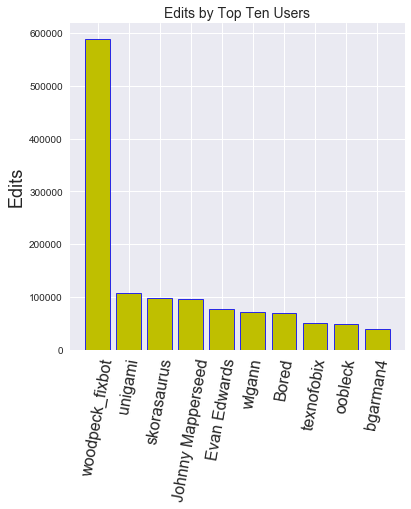

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
ind = np.arange(10)
ax.bar(ind, top_ten_df['Edits'], width =0.8, color='y', edgecolor='b', linewidth=0.8)
ax.set_xticks(ind)
ax.set_xticklabels(labels, rotation = 80, size = 16)
plt.title('Edits by Top Ten Users', size = 14); plt.ylabel('Edits', size = 18);


In [ ]:
from pylab import *
figure(1, figsize=(8,8))
ax = axes([0.1, 0.1, 0.8, 0.8])
explode = (0.00, 0.08)
labels = ['Top 10 Users Combined', 'Bottom 1290 Users Combined']
percents = ['62.56', '37.44']
pie(percents, explode=explode, labels=labels,
                autopct='%1.1f%%', shadow=True, startangle=90)

title('Total Edits Breakdown Cleveland OSM', size = 16);
font = {'weight' : 'bold',
        'size'   : 18}

matplotlib.rc('font', **font);

To put the discrepancy into even starker terms, the number of users who made only a single edit can be found.

``` 
query =
SELECT count(*) FROM 
(SELECT editer.user, count(*) as edits 
FROM (SELECT user FROM NODES 
UNION ALL SELECT user FROM WAYS 
UNION ALL SELECT user FROM relations) as editer 
GROUP BY editer.user HAVING edits=1);
```

__Users with a single edit = 234__

Clearly, the Cleveland OpenStreetMap is dominated by a few users while the vast majority of editors make only a few contributions. Nonetheless, on the positive side, 1300 people have contributed to the map, which demonstrates the wide interest in contributing to open-source community driven projects. 

### Leisure and Amenities

What sorts of leisure activites might one find in the great city of Cleveland? Well, using the SQL database, that question could be quickly answered. 

```python 

query =
SELECT a.value as leisure, count(*) as number FROM 
(SELECT key,value FROM nodes_tags UNION ALL 
SELECT key,value FROM relations_tags UNION ALL 
SELECT key,value from ways_tags) as a 
WHERE a.key='leisure'
GROUP BY a.value ORDER BY 
number DESC LIMIT 10;

leisure               number
--------------------  --------
pitch                 3044
park                  1140
playground            486
garden                414
swimming_pool         240
golf_course           187
picnic_table          152
track                 113
sports_centre         90
nature_reserve        77

```

I have to admit I was somewhat confused by the pitch identifier. However, a quick glance at the [OpenStreetMap wiki for pitch](http://wiki.openstreetmap.org/wiki/Tag:leisure%3Dpitch) reveals that the keyword pitch is for "an area designed for playing a particular sport, normally designated with appropriate markings. Examples include: tennis court, basketball court, ball park, riding arena." That makes much more sense. Now, I can see what types of sports those pitches are used for:

``` python 
query = SELECT a.value as sport, count(*) as number FROM 
(SELECT key,value FROM nodes_tags UNION ALL 
SELECT key,value FROM relations_tags UNION ALL 
SELECT key,value from ways_tags) as a 
WHERE a.key='sport' 
GROUP BY a.value 
ORDER BY number DESC LIMIT 10;

sport                 number
--------------------  --------
baseball              1621
tennis                440
basketball            285
soccer                247
american_football     172
golf                  94
multi                 55
volleyball            49
running               44
swimming              40

```

I would have expected basketball and American football to come out on top, but if each separate field or court is counted, then these numbers would be accurate. 
Next, I wanted to see the available amenities in Cleveland. 

```python

query = 
SELECT a.value as amenity, count(*) as number FROM 
(SELECT key,value FROM nodes_tags 
UNION ALL SELECT key,value FROM relations_tags
UNION ALL SELECT key, value FROM ways_tags) as a 
WHERE a.key='amenity' 
GROUP BY a.value 
ORDER BY number DESC LIMIT 10;

amenity               number
--------------------  --------
parking               4664
place_of_worship      1979
school                1538
restaurant            903
grave_yard            706
fast_food             673
fuel                  503
toilets               348
post_office           334
shelter               302
```


Having lived in Cleveland for several years, I can personally tell you that even with all of that parking, it can be hard to find a parking place downtown! Just for fun, I wondered what the most popular types of cuisine are in Cleveland.


```python

query =
SELECT a.value as cuisine_type, count(*) as number FROM 
(SELECT key,value FROM nodes_tags
UNION ALL SELECT key,value from ways_tags) as a
WHERE a.key='cuisine' 
GROUP BY a.value 
ORDER BY number DESC LIMIT 10;


cuisine_type          number
--------------------  --------
burger                174
pizza                 107
sandwich              87
mexican               78
american              74
coffee_shop           49
ice_cream             37
italian               35
chinese               34
chicken               20
```



Finally, because Cleveland is a city known for its river (not a day goes by when someone does not mention to me that the [Cuyahoga River is famous for catching on fire](http://www.ohiohistorycentral.org/w/Cuyahoga_River_Fire), although I am always wuite to add not since the 1970s) I decided to investigate the waterways. 

```python
query = 
SELECT value, COUNT(*) as number FROM ways_tags 
WHERE key ="waterway"
GROUP BY value 
ORDER BY number DESC LIMIT 5;

value                 number
--------------------  --------
stream                1017
river                 222
ditch                 171
riverbank             62
dam                   49

```
Those numbers seem a little high. I think what is occuring is that the same waterway is being tagged multiple times but in different places. I decided to group the waterways by name and then find how many times each waterway name appeared in the data:

```python 
query = 
SELECT ways_tags.value, COUNT(*) as number FROM ways_tags 
JOIN (SELECT DISTINCT(id) FROM ways_tags WHERE key='waterway') as water 
ON ways_tags.id = water.id 
WHERE ways_tags.key = "name" 
GROUP BY ways_tags.value 
ORDER BY number DESC LIMIT 5;

value                 number
--------------------  --------
Sandy Creek           75
Tuscarawas River      28
West Branch Nimishil  25
Little Cuyahoga Rive  21
Doan Brook            20

```

That looks a little more realistic. The famous Cuyahoga River does not even make it into the top 5. 

#### GNIS and TIGER data

Finally, I was interested to see where or even if users were sourcing their data from when were entering it onto the map. Looking through the CSV files, I had noticed that many tags were either GNIS or TIGER types. A quick search revealed that GNIS stands for the [Geographic Names Information System](https://geonames.usgs.gov/apex/f?p=138:1:1024104758715), created by the USGS. It is a database that contains over 2 million cultural and physical features in the United States. Many of the node tags and way tags appeared to reference from this database. The TIGER tag refers to the [Topologically Integrated Geographic Encoding and Referencing](https://www.census.gov/geo/maps-data/data/tiger.html) database from the US Census Bureau that includes features such as roads and rivers. These tags were applied to primarily the relations and also some of the ways. 

I wanted to see what percentage of each of the tags for nodes, ways, and relations were tied to either the GNIS or TIGER databases. 

In [ ]:
tables_to_query = ['nodes_tags', 'ways_tags', 'relations_tags']
for table in tables_to_query:
    # Find the number of elements that have been at least partially sourced from a database
    query_sourced_data = ("SELECT COUNT(DISTINCT(id)) FROM {} WHERE type='gnis' or type='tiger'".format(table))
    sourced_data = c.execute(query_sourced_data).fetchall()[0][0]
    # Find the total number of elements 
    query_total_data = ("SELECT COUNT(DISTINCT(id)) FROM {}".format(table))
    total_data = c.execute(query_total_data).fetchall()[0][0]
    percentage_sourced = (sourced_data / total_data) * 100
    element = table.split("_")[0]
    print("{:.2f}% of the data in the {} is at least partially sourced from a database.".format(percentage_sourced, element))

These statistics appear to be reasonable. The nodes for the most part are single points, and as such, do not have to be tied to a particular physical feature. The ways on the other hand, are composed of numerous nodes and often describe a route such as a highway or a trail that would be more likely to be found in a database. The relations usually describe a building or maybe a certain type of restriction such as no-left turn. Those would be less likely to be documented in a geographic database. Of course, there could be other databases besides GNIS and TIGER that I did not investigate, but this shows that a substantial portion of the ways in the Cleveland OSM data are based on verified features. 

### Additional Data Explorations

Cleveland city planners' favorite type of restrictions:

```python

query = 

SELECT value as restriction, count(*) as number FROM 
relations_tags WHERE key='restriction' 
GROUP BY value 
ORDER BY number dESC;

restriction           number
--------------------  --------
no_left_turn          423
no_u_turn             259
no_right_turn         156
only_straight_on      33
no_straight_on        22
only_right_turn       12
only_left_turn        3
```

Average number of nodes in a way:

```python
query = 
SELECT avg(number) FROM (SELECT count(*) as number FROM ways_nodes GROUP BY id);
```
__Average = 11.03__

Average number of members in a relation:
```python
query = 
SELECT avg(number) FROM (SELECT count(*) as number FROM relations_members GROUP BY id);
```
__Average = 6.59__

Max number of tags assigned to one node:
```python
query = 
SELECT max(number) FROM (SELECT count(*) as number FROM nodes_tags GROUP BY id);
```
__Max = 22__


### Additional Ideas

After observing the percentage of nodes, ways, and relations that have at least partially reference from a verified database, one potential idea to implement for the data would be to try and validate as many of the elements as is feasible. It should be possible to create a script that would read the XML file, and for each element, find the name tag of the feature and attempt to corroborate the information with an established database, whether that be GNIS, TIGER, or another option. For example, searching for "Doan Brook" in the GNIS database returns the following entry: 

"Feature Name"|"ID"|"Class"|"County"|"State"|"Latitude"|"Longitude"|"Ele(ft)"|"Map"|"BGN Date"|"Entry Date"|
"Doan Brook"|"1039725"|"Stream"|"Cuyahoga"|"OH"|"413230N"|"0813759W"|"577"|"Cleveland North"|""|"12-JUL-1979" 

This information could then be compared with the tags associated with "Doan Brook" in the OpenStreetMap and any incorrect user-entered information could be replaced with the validated data. This would be quite an undertaking for all of the elements in the original data, but it would vastly improve the quality of the data and reference it to a trusted source. 

The most intriguing aspect of the dataset to me was the skew in the percentage of edits made by users. I think it would be interesting to compare the quality of the data entered by bots compared to the quality of the data entered by users. Although bots should theoretically not make as many mistakes, they are programmed by humans, and an incorrectly designed bot could end up generating a large amount of "dirty" data with the creator never even realizing it. Humans users on the other hand, are slower but could potentially be more accurate and descriptive. Humans also have the advantage of being better able to judge the category a given feature should fall into and what tags should be associated with an element. Perhaps the best approach would be for bots to label the more straightforward features, such as nodes, and then have humans add in the details such as tags and descriptions that accurately model how the feature is used or experienced in the real world. These maps would not be possible to create in such detail without automated bots, but they occasionally need audits to ensure that the automated programs are not executing unintended actions. Moreover, humans are able to add nuanced data that even the most carefully programmed bot would never be able to figure out without having physically experienced the land being mapped. 


## Conclusions

Overall, I was surprised by the quality of the original dataset. There was far less invalid, inaccurate, or problematic data than I was expecting. To take a single example, I only had to correct 9 problem elevations out of nearly 6500 elevation tags in the data. OpenStreetMap seems to be an accurate model of the actual world, as shown by [at least one study](ftp://ftp.cits.rncan.gc.ca/pub/cartonat/Reference/VGI/Dissertation-OpenStreepMap-Quality-Aather-2009.pdf). The quality of any open-source project is directly dependent on the users, and it is clear that the OpenStreetMap users care deeply about ensuring that the map they have collectively created is complete and accurate. Similar to how a community of users were able to create an online encyclopedia, Wikipedia, that is [nearly as accurate as professionally produced encyclopedias](https://www.cnet.com/news/study-wikipedia-as-accurate-as-britannica/), the OpenStreetMap community has generated a remarkably accurate map of the world. 

Judging the completeness of the data is difficult without going through the city feature by feature and ensuring that it is accounted for in the OSM. However, I think that as a metro area, Cleveland would tend to be more complete than rural areas. I would expect that larger cities have more complete and accurate datasets because of the higher concentration of users to enter data. I would imagine that the real challenge for the OpenStreetMap community is creating accurate maps of rural communities that have decreased access to data and a wide user base willing to update a map. Perhaps this is why bots could be of greatest use. They could use GPS data or satellite pictures, perhaps coupled with machine learning, to identify different geographical and architectural features that could then be validated by a human user.  

This project was a great exercise in data auditing, cleaning, and analysis as well as the basics of creating and interacting with a SQL database. The next steps would be to actually implement the data cleaning by running the scripts on entire sections of the OSM data and then updating the map itself. OpenStreetMap is very consciously aware of [checking and improving the quality of the map](http://wiki.openstreetmap.org/wiki/Quality_assurance) and using automated tools, it should be possible to further improve on the relatively high quality of the Cleveland OpenStreetMap. 

#### Appendix: Size of Files

| File      | nodes.csv | ways.csv | relations.csv | nodes_tags.csv | ways_tags.csv | relations_tags.csv | ways_nodes.csv | relation_members.csv |
|-----------|-----------|----------|---------------|----------------|---------------|--------------------|----------------|----------------------|
| Size (MB) |   148.5   |   11.1   |      0.21     |       4.6      |      34.0     |        0.60        |      48.2      |         0.69         |

| File      | cleveland_ohio.xml | ClevelandOpenStreetMap.db |
|-----------|--------------------|---------------------------|
| Size (MB) |        392.6       |           223.0           |